In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics.classification import BinaryCalibrationError

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

from scipy.stats import wasserstein_distance
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from evidential import *
from util import *


In [7]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [8]:
def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)

In [9]:
# Set up device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(1)}")

Using cuda device NVIDIA TITAN V


In [10]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [250, 500, 1000, 2000, 3000, 5000, 10000]
bs_list = [128, 128, 128*2, 128*2, 1024, 1024, 1024*2]
#n_data = [10000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25
patience = 30
load_values = False
save_values = True

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nxMC_100_nr1MC_50"
gridfile = f"x1_x2_grid"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")
truth_data = truth_data[truth_data["r_x"] > R1_min-R2]

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

# Prepare data for pytorch

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = torch.zeros(X_test.shape)

X_grid = torch.Tensor(np.dstack((grid_data[x1_key], grid_data[x2_key]))).to(torch.float32)[0]
Y_grid = torch.zeros(X_grid.shape)

In [11]:
# Create datasets for pytorch
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
grid_dataset = torch.utils.data.TensorDataset(X_grid, Y_grid)

In [12]:
epochs = 100
lr = 0.001

test_dfs = [test_data.copy()]*len(n_data)
grid_dfs = [grid_data.copy()]*len(n_data)

for i in range(len(n_data)):
    if load_values == False:
        for j in tqdm(range(20)):
            n_train = n_data[i]
            batchsize = bs_list[i]
            logloss_min = 1 #Minimize this

            model = SequentialNet(L=200, n_hidden=5, activation="relu", in_channels=2, out_channels=2).to(device)

            optimizer = optim.Adam(model.parameters(), lr=lr)
            train_dataset = torch.utils.data.TensorDataset(X_train[0:n_train], Y_train[0:n_train])
            training_results = train_evidential_classifier(model, train_dataset, 
                                    val_dataset, batchsize=batchsize, epochs = epochs, 
                                    device = device, optimizer = optimizer, early_stopping=patience)
            
            
            # Prediction val set
            probs_val, uncertainties_val, beliefs_val = predict_evidential_classifier(model, val_dataset, 2, 100, device)
            preds_val = torch.argmax(probs_val, dim=-1).flatten()
            val_data["Est_prob_blue"] = probs_val[:,1] #Get probability score for blue

            ll = log_loss(val_data["class"], val_data["Est_prob_blue"])
            preds = torch.Tensor(val_data["Est_prob_blue"])
            target = torch.Tensor(val_data["class"])
            bce_l1 = BinaryCalibrationError(n_bins=15, norm='l1')
            ece = bce_l1(preds, target).item()
            print(f"n_train = {n_train}, lr={lr}, logloss={ll}, ECE= {ece}")

            if ll < logloss_min:
                print(f"New best values: n_train = {n_train}, lr={lr}, logloss={ll}, ECE= {ece}")
                logloss_min = ll

                # Prediction test set
                probs_test, uncertainties_test, beliefs_test = predict_evidential_classifier(model, test_dataset, 2, 100, device)
                preds_test = torch.argmax(probs_test, dim=-1).flatten()
                test_dfs[i]["Prediction"] = preds_test
                test_dfs[i]["Est_prob_blue"] = probs_test[:,1] #Get probability score for blue
                test_dfs[i]["Uncertainty"] = uncertainties_test[:,1]
                test_dfs[i]["0.5_uncertainty"] = uncertainties_test[:,1]/2
                test_dfs[i]["Beliefs"] = beliefs_test[:,1]

                # Prediction grid
                probs_grid, uncertainties_grid, beliefs_grid = predict_evidential_classifier(model, grid_dataset, 2, 100, device)
                preds_grid = torch.argmax(probs_grid, dim=-1).flatten()
                grid_dfs[i]["Prediction"] = preds_grid
                grid_dfs[i]["Est_prob_blue"] = probs_grid[:,1] #Get probability score for blue
                grid_dfs[i]["Uncertainty"] = uncertainties_grid[:,1]
                grid_dfs[i]["0.5_uncertainty"] = uncertainties_grid[:,1]/2
                grid_dfs[i]["Beliefs"] = beliefs_grid[:,1]

        # Save the best prediction
        if save_values:
            if (not os.path.isdir(f"predictions/{trainfile}") ):
                os.mkdir(f"predictions/{trainfile}")
            test_dfs[i].to_csv(f"predictions/{trainfile}/{testfile}_SequentialNet_evidential_best_ndata-{n_data[i]}.csv")
            grid_dfs[i].to_csv(f"predictions/{trainfile}/grid_{tag}_SequentialNet_evidential_best_ndata-{n_data[i]}.csv")
    else:

        test_dfs[i] = pd.read_csv(f"predictions/{trainfile}/{testfile}_SequentialNet_evidential_best_ndata-{n_data[i]}.csv")
        grid_dfs[i] = pd.read_csv(f"predictions/{trainfile}/grid_{tag}_SequentialNet_evidential_best_ndata-{n_data[i]}.csv")

 64%|██████▍   | 64/100 [00:05<00:03, 11.61it/s]


Stopping training early at epoch 64


100%|██████████| 50/50 [00:00<00:00, 442.37it/s]


n_train = 250, lr=0.001, logloss=0.5908344653507873, ECE= 0.09047731012105942
New best values: n_train = 250, lr=0.001, logloss=0.5908344653507873, ECE= 0.09047731012105942


100%|██████████| 50/50 [00:00<00:00, 454.97it/s]


n_train = 250, lr=0.001, logloss=0.6097176526932205, ECE= 0.11410020291805267
New best values: n_train = 250, lr=0.001, logloss=0.6097176526932205, ECE= 0.11410020291805267


 79%|███████▉  | 79/100 [00:06<00:01, 11.70it/s]


Stopping training early at epoch 79


100%|██████████| 50/50 [00:00<00:00, 456.74it/s]


n_train = 250, lr=0.001, logloss=0.5915595683251468, ECE= 0.09553246945142746
New best values: n_train = 250, lr=0.001, logloss=0.5915595683251468, ECE= 0.09553246945142746


100%|██████████| 50/50 [00:00<00:00, 451.90it/s]


n_train = 250, lr=0.001, logloss=0.6036240191283958, ECE= 0.0933138057589531
New best values: n_train = 250, lr=0.001, logloss=0.6036240191283958, ECE= 0.0933138057589531


 89%|████████▉ | 89/100 [00:07<00:00, 11.70it/s]


Stopping training early at epoch 89


100%|██████████| 50/50 [00:00<00:00, 464.16it/s]


n_train = 250, lr=0.001, logloss=0.6492567554773424, ECE= 0.13258278369903564
New best values: n_train = 250, lr=0.001, logloss=0.6492567554773424, ECE= 0.13258278369903564


 89%|████████▉ | 89/100 [00:07<00:00, 11.78it/s]


Stopping training early at epoch 89


100%|██████████| 50/50 [00:00<00:00, 463.94it/s]


n_train = 250, lr=0.001, logloss=0.6255268684731035, ECE= 0.12273456156253815
New best values: n_train = 250, lr=0.001, logloss=0.6255268684731035, ECE= 0.12273456156253815


100%|██████████| 50/50 [00:00<00:00, 460.66it/s]


n_train = 250, lr=0.001, logloss=0.6688294971491073, ECE= 0.14313308894634247
New best values: n_train = 250, lr=0.001, logloss=0.6688294971491073, ECE= 0.14313308894634247


 94%|█████████▍| 94/100 [00:07<00:00, 11.77it/s]


Stopping training early at epoch 94


100%|██████████| 50/50 [00:00<00:00, 463.97it/s]


n_train = 250, lr=0.001, logloss=0.6255357791135666, ECE= 0.10096082836389542
New best values: n_train = 250, lr=0.001, logloss=0.6255357791135666, ECE= 0.10096082836389542


 74%|███████▍  | 74/100 [00:06<00:02, 11.77it/s]


Stopping training early at epoch 74


100%|██████████| 50/50 [00:00<00:00, 464.21it/s]


n_train = 250, lr=0.001, logloss=0.5974832996991514, ECE= 0.09013129770755768
New best values: n_train = 250, lr=0.001, logloss=0.5974832996991514, ECE= 0.09013129770755768


 59%|█████▉    | 59/100 [00:04<00:03, 11.82it/s]


Stopping training early at epoch 59


100%|██████████| 50/50 [00:00<00:00, 459.66it/s]


n_train = 250, lr=0.001, logloss=0.6112061346573114, ECE= 0.1029338613152504
New best values: n_train = 250, lr=0.001, logloss=0.6112061346573114, ECE= 0.1029338613152504


 54%|█████▍    | 54/100 [00:04<00:03, 11.66it/s]


Stopping training early at epoch 54


100%|██████████| 50/50 [00:00<00:00, 461.60it/s]


n_train = 250, lr=0.001, logloss=0.5905739937254769, ECE= 0.06915125250816345
New best values: n_train = 250, lr=0.001, logloss=0.5905739937254769, ECE= 0.06915125250816345


100%|██████████| 50/50 [00:00<00:00, 460.93it/s]


n_train = 250, lr=0.001, logloss=0.5938604260001005, ECE= 0.09370815753936768
New best values: n_train = 250, lr=0.001, logloss=0.5938604260001005, ECE= 0.09370815753936768


 74%|███████▍  | 74/100 [00:06<00:02, 11.85it/s]


Stopping training early at epoch 74


100%|██████████| 50/50 [00:00<00:00, 451.02it/s]


n_train = 250, lr=0.001, logloss=0.5748412520838541, ECE= 0.06758499145507812
New best values: n_train = 250, lr=0.001, logloss=0.5748412520838541, ECE= 0.06758499145507812


 54%|█████▍    | 54/100 [00:04<00:03, 11.70it/s]


Stopping training early at epoch 54


100%|██████████| 50/50 [00:00<00:00, 451.63it/s]


n_train = 250, lr=0.001, logloss=0.5837546553510813, ECE= 0.07178831845521927
New best values: n_train = 250, lr=0.001, logloss=0.5837546553510813, ECE= 0.07178831845521927


 54%|█████▍    | 54/100 [00:04<00:03, 12.91it/s]


Stopping training early at epoch 54


100%|██████████| 50/50 [00:00<00:00, 453.28it/s]


n_train = 250, lr=0.001, logloss=0.5932393208363345, ECE= 0.09843770414590836
New best values: n_train = 250, lr=0.001, logloss=0.5932393208363345, ECE= 0.09843770414590836


 79%|███████▉  | 79/100 [00:06<00:01, 11.97it/s]


Stopping training early at epoch 79


100%|██████████| 50/50 [00:00<00:00, 466.09it/s]


n_train = 250, lr=0.001, logloss=0.5953670232419261, ECE= 0.11201641708612442
New best values: n_train = 250, lr=0.001, logloss=0.5953670232419261, ECE= 0.11201641708612442


 69%|██████▉   | 69/100 [00:05<00:02, 11.82it/s]


Stopping training early at epoch 69


100%|██████████| 50/50 [00:00<00:00, 486.27it/s]


n_train = 250, lr=0.001, logloss=0.607179813071149, ECE= 0.11605490744113922
New best values: n_train = 250, lr=0.001, logloss=0.607179813071149, ECE= 0.11605490744113922


 69%|██████▉   | 69/100 [00:05<00:02, 11.80it/s]


Stopping training early at epoch 69


100%|██████████| 50/50 [00:00<00:00, 453.73it/s]


n_train = 250, lr=0.001, logloss=0.6249746427606234, ECE= 0.11731550097465515
New best values: n_train = 250, lr=0.001, logloss=0.6249746427606234, ECE= 0.11731550097465515


 59%|█████▉    | 59/100 [00:04<00:03, 12.00it/s]


Stopping training early at epoch 59


100%|██████████| 50/50 [00:00<00:00, 455.28it/s]


n_train = 250, lr=0.001, logloss=0.5993514877918796, ECE= 0.08966328948736191
New best values: n_train = 250, lr=0.001, logloss=0.5993514877918796, ECE= 0.08966328948736191


 69%|██████▉   | 69/100 [00:05<00:02, 11.71it/s]


Stopping training early at epoch 69


100%|██████████| 50/50 [00:00<00:00, 461.07it/s]


n_train = 250, lr=0.001, logloss=0.5987407462039408, ECE= 0.09959813207387924
New best values: n_train = 250, lr=0.001, logloss=0.5987407462039408, ECE= 0.09959813207387924


100%|██████████| 20/20 [02:19<00:00,  7.00s/it]


KeyError: 0

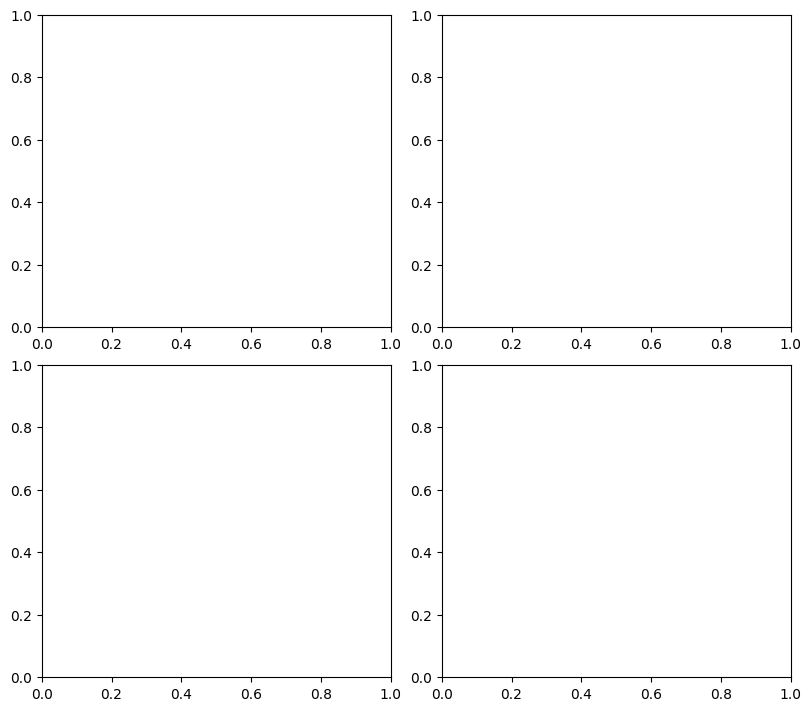

In [13]:
for i in range(len(n_data)):
    # Plot
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

    axs[0][0] = plot_results(test_data[i], "Est_prob_blue", axs[0][0], "Test data", error_key="0.5_uncertainty", rmax=grid_rmax)
    axs[0][1] = plot_results(grid_data[i], "Est_prob_blue", axs[0][1], "Estimated distribution", grid=True, rmax=grid_rmax)
    axs[1][1] = plot_conf_matrix(test_data[i], "class", "Prediction", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")


    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_train}", size=16, fontweight="bold")


<Axes: xlabel='r', ylabel='Count'>

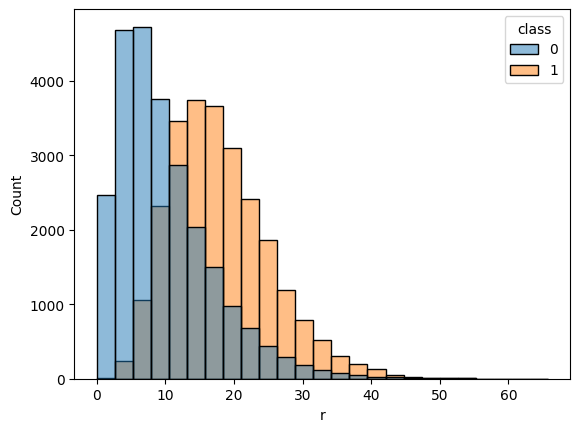

In [ ]:
sn.histplot(train_data, x="r", hue="class", bins=25)
#plt.xlim(25, 30)
#plt.ylim(0, 30)

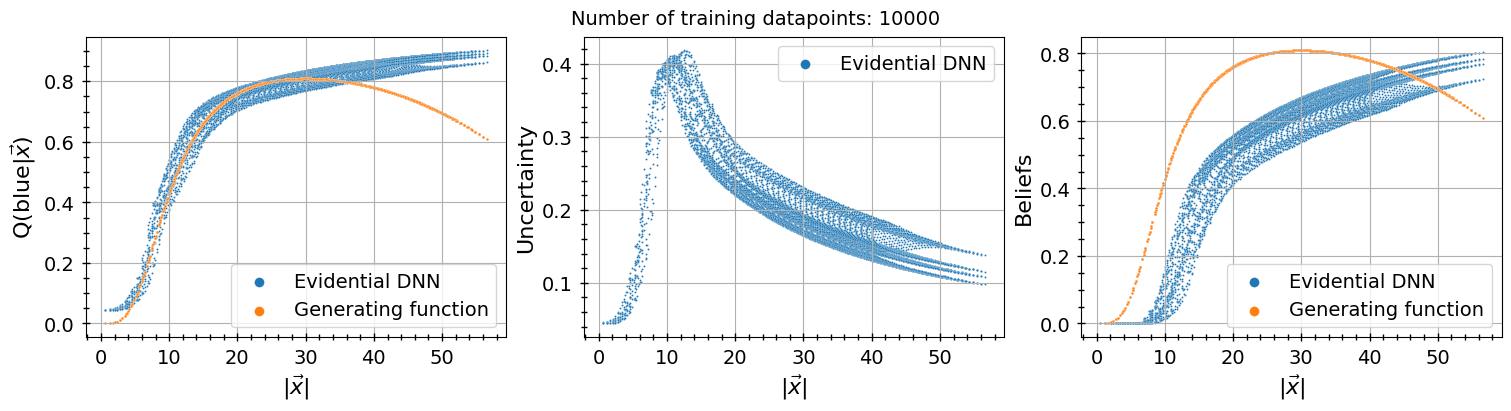

In [ ]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize= (5*3, 4), layout="constrained")

    sn.scatterplot(grid_data[i], x="r", y="Est_prob_blue", s=2, ax = axs[0], label ="Evidential DNN")
    sn.scatterplot(grid_data[i], x="r", y="p_c1_given_r", s=2, ax = axs[0], label="Generating function")
    axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_data[i], x="r", y="0.5_uncertainty", s=2, ax = axs[1], label ="Evidential DNN")
    axs[1].set_ylabel(r"Uncertainty", fontsize=16)

    sn.scatterplot(grid_data[i], x="r", y="Beliefs", s=2, ax = axs[2], label ="Evidential DNN")
    sn.scatterplot(grid_data[i], x="r", y="p_c1_given_r", s=2, ax = axs[2], label="Generating function")
    axs[2].set_ylabel(r"Beliefs", fontsize=16)

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)
    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.legend(markerscale=5, fontsize=14)

Text(0.5, 0.98, 'Number of training datapoints: 10000')

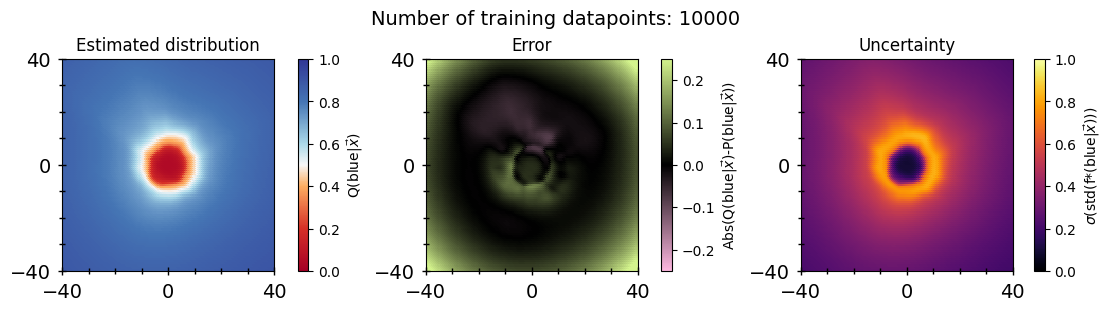

In [ ]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")

    axs[0] = plot_results(grid_data[i], "Est_prob_blue", axs[0], "Estimated distribution", grid=True, rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), label=r"Q(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_data[i], grid_data[0], "Est_prob_blue", "p_c1_given_r", axs[1], r"Error", max_val=0.25, rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=-0.25, vmax=0.25, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), label=r"Abs(Q(blue|$\vec{x}$)-P(blue|$\vec{x}$))", ax=axs[1])

    axs[2] = plot_std(grid_data[i], "Uncertainty", axs[2], "Uncertainty", grid=True, max_val=1, rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"),  fraction=0.050, pad=0.04,
                    label=r"$\sigma$(std(f*(blue|$\vec{x}$)))", ax=axs[2])

    fig.suptitle(f"Number of training datapoints: {n_train}", fontsize=14)


Text(0.5, 0.98, 'Number of training datapoints: 10000')

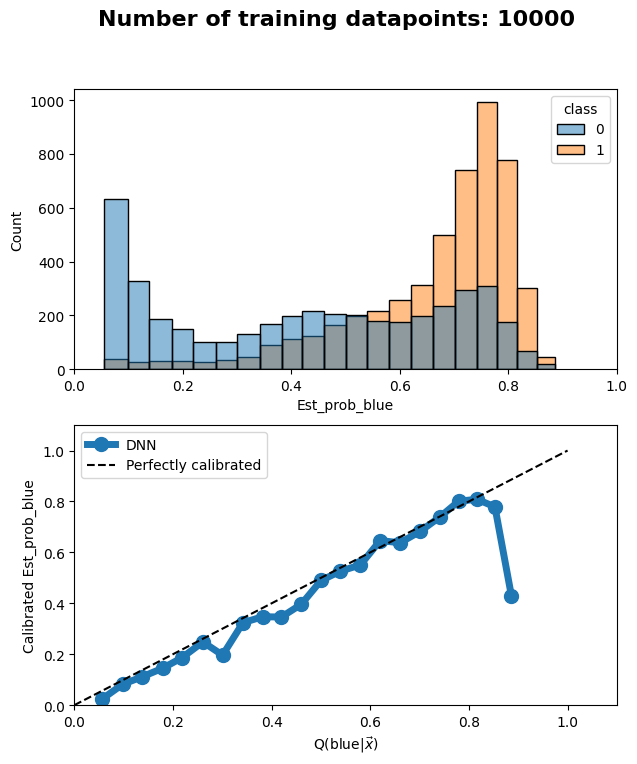

In [ ]:
for i in range(len(n_data)):

    prob_cal, prob_pred = calibration_curve(test_data[i]["class"], test_data[i]["Est_prob_blue"], n_bins=25, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 8))
    sn.histplot(test_data[i], x="Est_prob_blue", hue="class", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel(r"Q(blue|$\vec{x}$)")
    ax[1].set_ylabel("Calibrated Est_prob_blue")
    ax[1].legend()
    fig.suptitle(f"Number of training datapoints: {n_train}", size=16, fontweight="bold")